In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , f1_score , roc_auc_score , precision_score , recall_score , accuracy_score
from xgboost import XGBClassifier
import lightgbm as lgbm


**One hot encode Categorical values**

In [90]:
loan_df = pd.read_csv('eda_out.csv')

In [91]:
purpose_cat = list(loan_df['purpose'].unique())
purpose_cat

['debt_consolidation',
 'credit_card',
 'all_other',
 'home_improvement',
 'small_business',
 'major_purchase',
 'educational']

In [92]:
onehot_encoder = OneHotEncoder( sparse=False)
onehot_encoded = onehot_encoder.fit_transform(loan_df['purpose'].values.reshape(-1,1))
onehot_encoded_df = pd.DataFrame(onehot_encoded , columns= onehot_encoder.get_feature_names_out())
onehot_encoded_df.head()


/Users/dbvaddi/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,x0_all_other,x0_credit_card,x0_debt_consolidation,x0_educational,x0_home_improvement,x0_major_purchase,x0_small_business
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [93]:
loan_df_ohe = loan_df.join(onehot_encoded_df)

In [94]:
loan_df = loan_df_ohe.drop('purpose', axis=1)
loan_df.drop(loan_df.columns[loan_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
loan_df.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,x0_all_other,x0_credit_card,x0_debt_consolidation,x0_educational,x0_home_improvement,x0_major_purchase,x0_small_business
0,True,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,True,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,True,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,True,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,True,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0


**Define X and y , Split Train/test and Scale**

In [95]:
X = loan_df.drop(columns = 'not.fully.paid')
y = loan_df['not.fully.paid']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 11, stratify = y)

In [97]:
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [98]:
## function to dispaly confusion matrix
def disp_cm( y_test  , ytest_pred ):
    cm = confusion_matrix(y_test, ytest_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()    

In [99]:
results_df = pd.DataFrame(columns=['model_name','f1' , 'roc_auc' 
                                   , 'precision' , 'recall' , 'accuracy'
])

In [100]:
def score_calc(model_name , y_test,ytest_pred):
    roc_auc = roc_auc_score(y_test,ytest_pred)
    f1 = f1_score(y_test, ytest_pred)
    precision = precision_score(y_test, ytest_pred)
    recall = recall_score(y_test,ytest_pred)
    accuracy = accuracy_score(y_test , ytest_pred)
    append_res(model_name,f1, roc_auc, precision,recall , accuracy)

In [101]:
## insert into dataframe 
def append_res(model_name , f1 , roc_auc , precision , recall , accuracy):
    results_df.loc[len(results_df.index)] = [model_name , f1 , roc_auc , precision , recall , accuracy]

## Basic Logreg for baseline

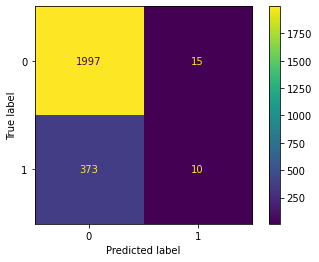

In [102]:
lr = LogisticRegression()
lr.fit(Xs_train,y_train)
lr.score(Xs_train,y_train) , lr.score(Xs_test,y_test)
y_pred_lr = lr.predict(Xs_test)
score_calc('logreg',y_test , y_pred_lr)
disp_cm(y_test , y_pred_lr)

## XGBoost

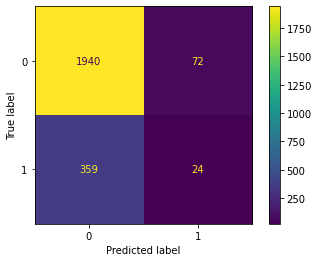

In [103]:
xgbc_base = XGBClassifier(random_state=0)
xgbc_base.fit(Xs_train, y_train)
y_pred_xg = xgbc_base.predict(Xs_test)
score_calc('XGBoost', y_test , y_pred_xg)
disp_cm(y_test , y_pred_xg)


## XGboost Scale Pos adjusted

In [105]:
loan_df['not.fully.paid'].value_counts()

not.fully.paid
False    8045
True     1533
Name: count, dtype: int64

In [106]:
8045/1533

5.247879973907371

In [107]:
y_test.value_counts()

not.fully.paid
False    2012
True      383
Name: count, dtype: int64

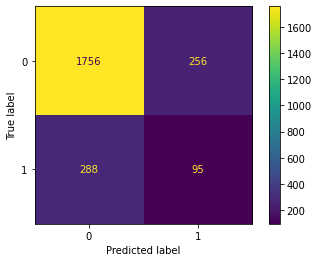

In [108]:
xgbc_pos5 = XGBClassifier(random_state=0, scale_pos_weight= 5)
xgbc_pos5.fit(Xs_train, y_train)
y_pred_xg5 = xgbc_pos5.predict(Xs_test)
score_calc('XGBoost_pos5', y_test , y_pred_xg5)
disp_cm(y_test , y_pred_xg5)

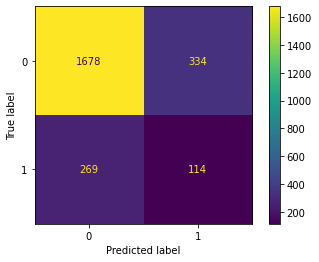

In [110]:
xgbc_pos7 = XGBClassifier(random_state=0, scale_pos_weight= 7)
xgbc_pos7.fit(Xs_train, y_train)
y_pred_xg7 = xgbc_pos7.predict(Xs_test)
score_calc('XGBoost_pos7', y_test , y_pred_xg7)
disp_cm(y_test , y_pred_xg7)

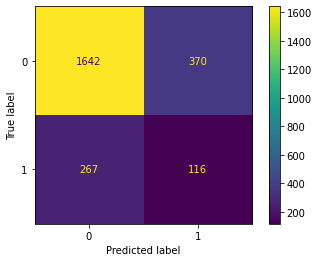

In [112]:
xgbc_pos9 = XGBClassifier(random_state=0, scale_pos_weight= 9)
xgbc_pos9.fit(Xs_train, y_train)
y_pred_xg9 = xgbc_pos9.predict(Xs_test)
score_calc('XGBoost_pos9', y_test , y_pred_xg9)
disp_cm(y_test , y_pred_xg9)

In [113]:
results_df

,model_name,f1,roc_auc,precision,recall,accuracy
0,logreg,0.049020,0.509327,0.400000,0.026110,0.837996
1,XGBoost,0.100209,0.513439,0.250000,0.062663,0.820042
2,XGBoost_pos5,0.258856,0.560403,0.270655,0.248042,0.772860
3,XGBoost_pos7,0.274368,0.565823,0.254464,0.297650,0.748225
4,XGBoost_pos9,0.266974,0.559488,0.238683,0.302872,0.734029
